# PREENTREGA PROYECTO FINAL: Muertes por COVID-19 en Argentina

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import ydata_profiling

## Introducción
El coronavirus es una enfermedad infecciosa causada por el virus SARS-CoV-2.
El brote actual, conocido como COVID-19, fue identificado por primera vez en Wuhan, China en diciembre de 2019 y fue declarado una pandemia por la Organización Mundial de la Salud (OMS). Desde entonces, se ha propagado por todo el mundo probocando la mayor crisis de salud pública que el mundo ha enfrentado en más de un siglo.

## Objetivo
El objetivo de este proyecto es **analizar la evolución temporal de las muertes relacionadas con COVID-19** en Argentina, identificar patrones y tendencias, así como evaluar la efectividad de las medidas implementadas para mitigar el impacto del virus en la mortalidad. Se utilizarán técnicas de análisis de series de tiempo y aprendizaje automático para identificar factores asociados con las variaciones en la tasa de mortalidad y **predecir la evolución futura** de la misma. Los resultados se utilizarán para informar la toma de decisiones y la implementación de estrategias efectivas para reducir el número de muertes relacionadas con COVID-19 en el país.

Este objetivo específico ayudaría a enfocar el análisis en la comprensión de la propagación del virus en el pasado y a utilizar los resultados para desarrollar estrategias efectivas de prevención y respuesta en caso de que el virus vuelva a propagarse.

## Audiencia
Una empresa farmacéutica que busca desarrollar y comercializar productos antivirales para prevenir y tratar infecciones virales similares al COVID-19. \
Utilizando los datos y resultados obtenidos, la empresa podría identificar los patrones y factores de riesgo asociados con la propagación del COVID-19 en el pasado y utilizar esta información para desarrollar productos antivirales específicos que puedan ser efectivos contra otros virus similares o una nueva propagación del COVID-19. Al estar mejor preparados para futuras pandemias, la empresa podría posicionarse como líder en la lucha contra las infecciones virales y aprovechar las oportunidades de negocio asociadas.

En resumen, el análisis de muertes confirmadas por COVID-19 podría proporcionar información valiosa para las empresas que buscan estar mejor preparadas para futuras pandemias, permitiéndoles tomar decisiones informadas y desarrollar productos y estrategias efectivas para prevenir y tratar infecciones virales.

## Hipótesis/Preguntas
* ¿La implementación de medidas de prevención y control del virus en Argentina permitió que las muertes por COVID-19 desciendan en el tiempo?
* ¿El número de muertes por COVID-19 en Argentina ha sido inferior al de otros países con características socioeconómicas y sanitarias similares?

## Exploración de datos

In [2]:
# Carga de datos CSV
data = pd.read_csv('../owid-covid-data.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [3]:
# Información del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255132 entries, 0 to 255131
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    255132 non-null  object        
 1   continent                                   240808 non-null  object        
 2   location                                    255132 non-null  object        
 3   date                                        255132 non-null  datetime64[ns]
 4   total_cases                                 240714 non-null  float64       
 5   new_cases                                   240396 non-null  float64       
 6   new_cases_smoothed                          239192 non-null  float64       
 7   total_deaths                                221101 non-null  float64       
 8   new_deaths                                  221007 non-null  float64      

In [4]:
# Duplicados
print(data.duplicated().value_counts())

False    255132
dtype: int64


La organización Our World In Data agregó información al dataset existente diferenciando las regiones con el prefijo 'OWID_'. Y en los casos donde no contaban con información suficiente, lo agregaron por otra característica como por ejemplo: High Income, International, World, etc.

Para nuestro análisis, esta información no es relevante, por lo que vamos a eliminarla.

In [5]:
# Lista de iso_code a eliminar
owid_iso = data[data.iso_code.str.contains('OWID_')].iso_code.unique()

# Lista de indice con iso_code en lista a eliminar
drop_index = data.loc[data['iso_code'].isin(owid_iso)].index
data = data.drop(index=drop_index)

In [6]:
# Descripción de los datos
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_cases,225339.0,1.306823e+06,5.595041e+06,1.000000,5042.000000,4.736200e+04,4.672700e+05,1.025902e+08
new_cases,225014.0,2.976001e+03,1.781941e+04,0.000000,0.000000,2.800000e+01,5.730000e+02,1.354502e+06
new_cases_smoothed,223880.0,2.985579e+03,1.649192e+04,0.000000,4.000000,6.257100e+01,7.255710e+02,8.069601e+05
total_deaths,205920.0,2.035180e+04,7.746025e+04,1.000000,114.000000,1.023000e+03,8.232000e+03,1.111495e+06
new_deaths,205647.0,3.308319e+01,2.114698e+02,0.000000,0.000000,0.000000e+00,8.000000e+00,5.989500e+04
...,...,...,...,...,...,...,...,...
population,234776.0,3.698911e+07,1.428097e+08,47.000000,695180.000000,6.630621e+06,2.617741e+07,1.425887e+09
excess_mortality_cumulative_absolute,8349.0,5.075168e+04,1.400434e+05,-37726.100000,66.200000,6.743500e+03,3.662220e+04,1.253112e+06
excess_mortality_cumulative,8349.0,1.010110e+01,1.324491e+01,-28.450000,0.890000,7.800000e+00,1.574000e+01,7.655000e+01
excess_mortality,8388.0,1.404808e+01,2.578767e+01,-95.920000,0.187500,7.480000e+00,1.901750e+01,3.767700e+02


De la información obtenida anteriormente podemos concluir que:
1. Se analizaron 248 paises
2. Casos por día va entre 0 y 1.354.502, siendo la media de 2.976,001. Y el total de casos de COVID-19 va entre 1 (posibles outliers) y 102.590.200, siendo la media de 1.306.823
3. Muertes por día va entre 0 y 59.894,9, siendo la media de 33,08. Y total de muertes va entre 1 (posibles outliers) y 1.111.495, siendo la media de 20.351,8
4. El total de vacunaciones va entre 0 (posibles valores nulos) y 3.490.419.000, siendo la media de 80.355.840
5. Las personas vacunadas entre 0 (posibles valores nulos) y 1.310.267.000, siendo la media de 26.977.200

### Paises con mayor cantidad de muertes

Analizamos la cantidad de muertes a nivel mundial.

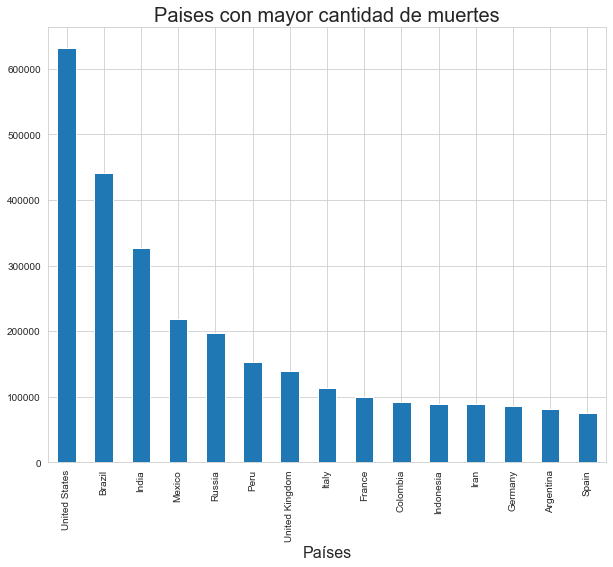

In [7]:
# Paises con mayor cantidad de muertes por COVID-19
temp = data.groupby('location').mean().sort_values('total_deaths', ascending=False)

temp['total_deaths'].head(15).plot.bar(figsize=(10, 8))
plt.title('Paises con mayor cantidad de muertes', fontsize=20)
plt.xlabel('Países', fontsize=16)
plt.show()

A continuación nos vamos a centrar en analizar las muertes y vacunaciones en Argentina

In [8]:
# Nuevo dataset con los valores de Argentina
arg_data = data[data['iso_code'] == 'ARG']
arg_data = arg_data.set_index('date')
arg_data.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN
2020-01-02,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN
2020-01-03,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN
2020-01-04,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN
2020-01-05,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN


In [9]:
arg_data.shape

(1131, 66)

In [10]:
# Valores duplicados
arg_data.duplicated().value_counts()

False    1122
True        9
dtype: int64

In [11]:
arg_data.drop_duplicates(inplace=True)
arg_data.duplicated().value_counts()

False    1122
dtype: int64

In [12]:
# Valores nulos
arg_data.isnull().sum()

iso_code                                      0
continent                                     0
location                                      0
total_cases                                  53
new_cases                                    58
                                           ... 
population                                    0
excess_mortality_cumulative_absolute       1110
excess_mortality_cumulative                1110
excess_mortality                           1110
excess_mortality_cumulative_per_million    1110
Length: 66, dtype: int64

In [13]:
# Posible outlier
arg_data[arg_data.new_deaths_per_million >= 70]

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,ARG,South America,Argentina,765002.0,14001.0,12390.857,20288.0,3351.0,788.857,16809.417,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN


In [14]:
arg_data.drop('2020-10-01', axis=0, inplace=True)

El día 2020-10-01 se registraron más de 73 millones de muertes y no concuerda con la información registrada los siguientes días, por lo que decido eliminar el registro de ese día.

### Evolución de la tasa de mortalidad por COVID-19 en Argentina

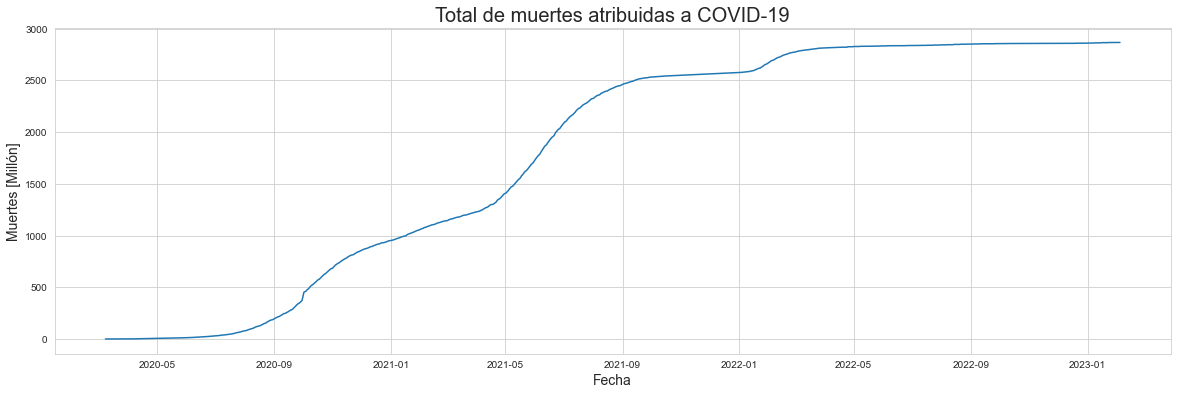

In [15]:
# Total de muertes atribuidas a COVID-19
fig = plt.figure(figsize=(20, 6))
ax = sns.lineplot(data=arg_data, x='date', y='total_deaths_per_million')
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Muertes [Millón]', fontsize=14)
ax.set_title('Total de muertes atribuidas a COVID-19', fontsize=20)
plt.show()


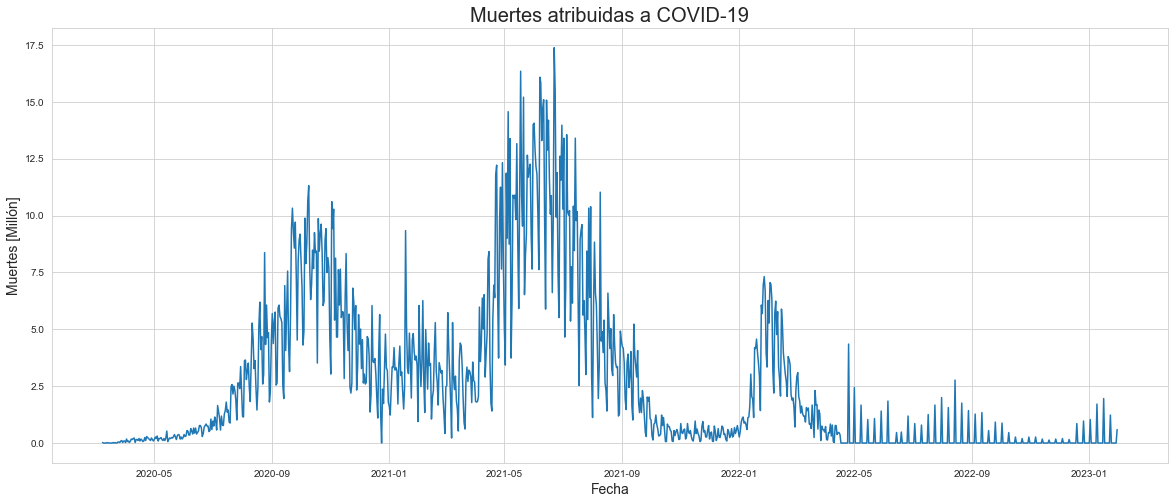

In [16]:
# Muertes atribuidas a COVID-19
fig = plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=arg_data, x='date', y='new_deaths_per_million')
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Muertes [Millón]', fontsize=14)
ax.set_title('Muertes atribuidas a COVID-19', fontsize=20)
plt.show()

En los gráficos se puede observar que el periodo en el que se registró la mayor cantidad de muertes por COVID-19 en Argentina fue durante la segunda ola de la pandemia, que tuvo lugar entre abril y agosto de 2021, lo que representó un aumento significativo en comparación con la primera ola de la pandemia en 2020. \
También podemos notar que la cantidad de casos y muertes ha disminuido desde entonces.

### Evolución de vacunaciones en Argentina

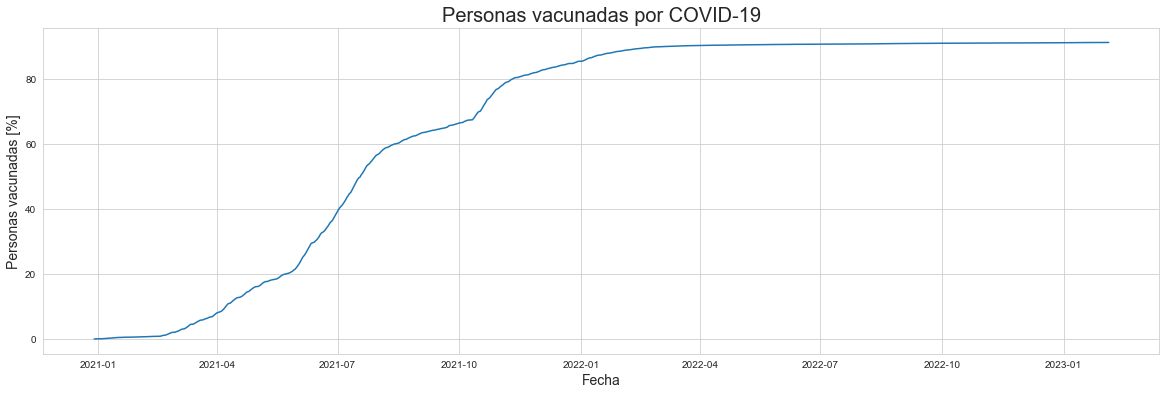

In [17]:
# Total de vacunaciones de COVID-19
fig = plt.figure(figsize=(20, 6))
ax = sns.lineplot(data=arg_data, x='date', y='people_vaccinated_per_hundred')
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Personas vacunadas [%]', fontsize=14)
ax.set_title('Personas vacunadas por COVID-19', fontsize=20)
plt.show()


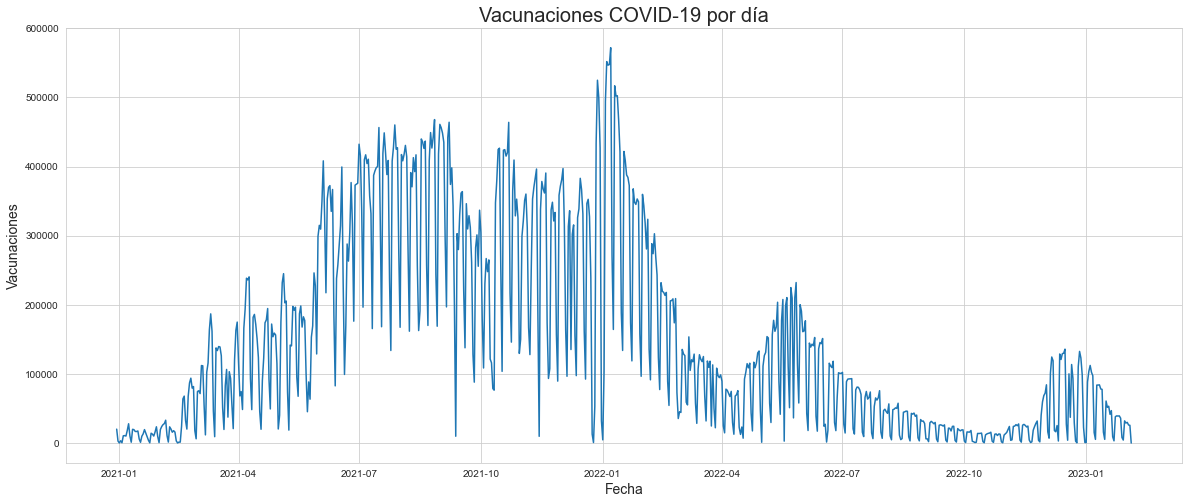

In [18]:
# Vacunaciones por COVID-19 por día
fig = plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=arg_data, x='date', y='new_vaccinations')
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Vacunaciones', fontsize=14)
ax.set_title('Vacunaciones COVID-19 por día', fontsize=20)
plt.show()


In [19]:
# Formula para normalizar valores
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (
            df[feature_name] - min_val) / (max_val - min_val)
    return result

df_norm = normalize(arg_data[['total_vaccinations', 'total_deaths']])

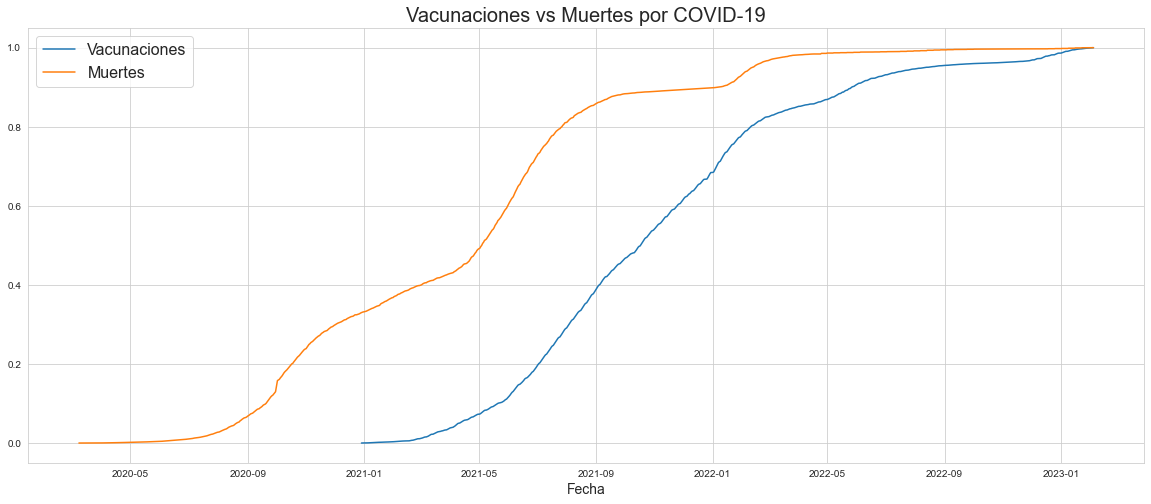

In [20]:
# Muertes y vacunaciones
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df_norm.index, df_norm.total_vaccinations, label='Vacunaciones')
ax.plot(df_norm.index, df_norm.total_deaths, label='Muertes', color='C1')
ax.set_xlabel('Fecha', fontsize=14)
ax.set_title('Vacunaciones vs Muertes por COVID-19', fontsize=20)
ax.legend(fontsize=16)
plt.show()

En los gráficos sobre vacunaciones se puede observar que el período en que se realizaron más vacunaciones fue desde mayo 2021 a enero 2022, y se relaciona con el número de muertes.

### Comparación Argentina con otros países con características socioeconómicas y sanitarias similares

Chile, Uruguay y México fueron los paises elegidos para compararse con Argentina por sus siguentes similitudes:

* Chile y Argentina tienen una estructura económica similar basada en la exportación de productos primarios, como los productos agrícolas y minerales. También comparten desafíos en materia de desigualdad social y acceso a servicios de salud.
* Uruguay: Uruguay es un país de tamaño y estructura económica similar a Argentina, con una importante presencia de la producción agropecuaria y una industria en desarrollo, y ambos tienen una población envejecida. Tanto Argentina como Uruguay tienen altos niveles de desigualdad social, lo que se refleja en la distribución de ingresos y acceso a servicios básicos.
* México: México y Argentina son países con grandes economías regionales y ambos comparten una historia de conflictos políticos y sociales. También tienen en común desafíos en cuanto a la atención de la salud, especialmente en áreas rurales y marginadas.

In [21]:
comp_data = data[data['iso_code'].isin(['CHL', 'ARG', 'MEX', 'URY'])]
comp_data.set_index('date', inplace=True)
comp_data.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN
2020-01-02,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN
2020-01-03,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN
2020-01-04,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN
2020-01-05,ARG,South America,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.0,76.67,0.845,45510324.0,NaN,NaN,NaN,NaN


In [22]:
# Duplicados
print(comp_data.duplicated().value_counts())
comp_data = comp_data.drop_duplicates()
comp_data.duplicated().value_counts()

False    4381
True       18
dtype: int64


False    4381
dtype: int64

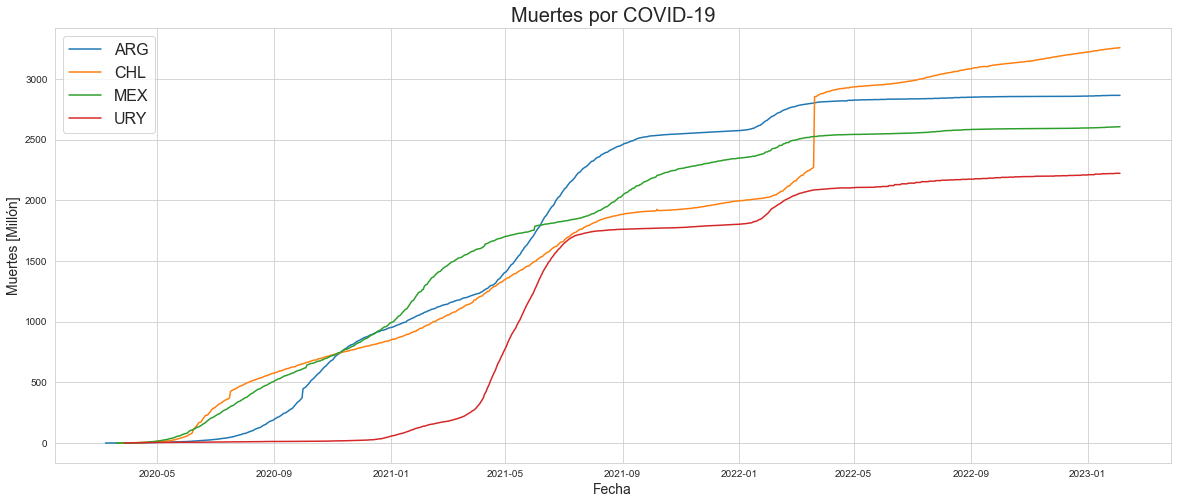

In [23]:
# Comparación taza de mortalidad
fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.lineplot(data=comp_data, x='date', y='total_deaths_per_million', hue='iso_code')
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Muertes [Millón]', fontsize=14)
ax.set_title('Muertes por COVID-19', fontsize=20)
ax.legend(fontsize=16)
plt.show()

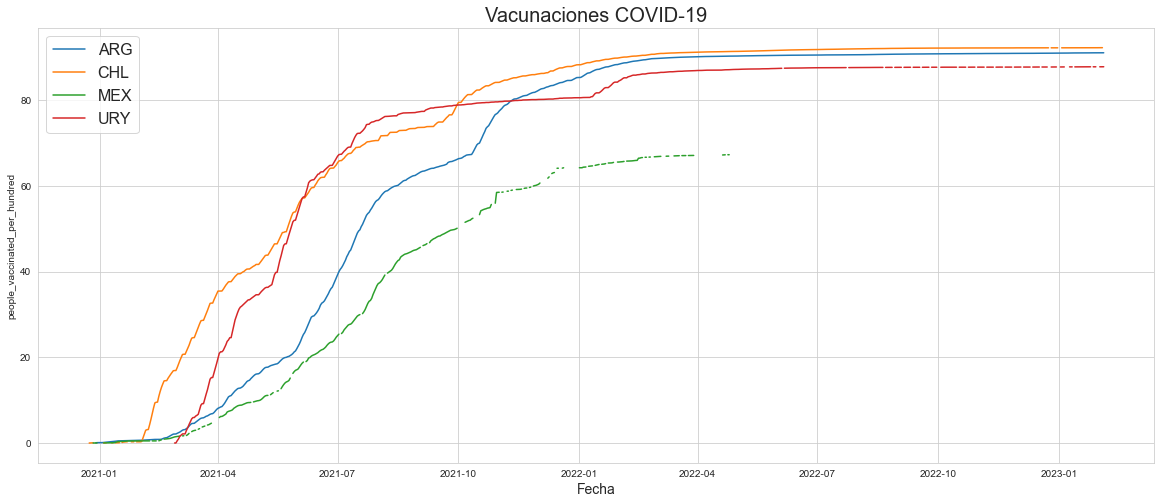

In [24]:
# Comparación vacunaciones
fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.lineplot(data=comp_data, x='date', y='people_vaccinated_per_hundred', hue='iso_code')
ax.set_xlabel('Fecha', fontsize=14)
ax.set_title('Vacunaciones COVID-19', fontsize=20)
ax.legend(fontsize=16)
plt.show()


Después de analizar los datos de muertes por COVID-19 en Argentina, Chile, Uruguay y México, se ha encontrado que el número de muertes en Argentina ha sido inferior en comparación con Chile y bastante superior comparando con Uruguay. Esto se puede deber a la implementación de políticas de prevención y control del virus similares a los demás países, como el uso de barbijos, distanciamiento social y medidas de higiene adecuadas.

## Muertes por COVID-19 en relación con casos positivos y hospitalizaciones

In [25]:
# Carga de datos API
url = "https://api.covidtracking.com/v1/us/daily.json"
# url = "https://api.covid19api.com/summary"
df = requests.get(url)
print(df)

# Transformar a json
json_data = json.loads(df.text)

# Crear dataframe
data_api = pd.DataFrame.from_dict(json_data)
data_api.head()

<Response [200]>


,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20210307,56,28756489.0,74582825.0,11808.0,40199.0,776361.0,8134.0,45475.0,2802.0,...,2021-03-07T24:00:00Z,None,0,0,842,726,131835,41835,1170059,a80d0063822e251249fd9a44730c49cb23defd83
1,20210306,56,28714654.0,74450990.0,11783.0,41401.0,775635.0,8409.0,45453.0,2811.0,...,2021-03-06T24:00:00Z,None,0,0,1680,503,143835,60015,1430992,dae5e558c24adb86686bbd58c08cce5f610b8bb0
2,20210305,56,28654639.0,74307155.0,12213.0,42541.0,775132.0,8634.0,45373.0,2889.0,...,2021-03-05T24:00:00Z,None,0,0,2221,2781,271917,68787,1744417,724844c01659d0103801c57c0f72bf8cc8ab025c
3,20210304,56,28585852.0,74035238.0,12405.0,44172.0,772351.0,8970.0,45293.0,2973.0,...,2021-03-04T24:00:00Z,None,0,0,1743,1530,177957,65487,1590984,5c549ad30f9abf48dc5de36d20fa707014be1ff3
4,20210303,56,28520365.0,73857281.0,11778.0,45462.0,770821.0,9359.0,45214.0,3094.0,...,2021-03-03T24:00:00Z,None,0,0,2449,2172,267001,66836,1406795,fef6c425d2b773a9221fe353f13852f3e4a4bfb0


## Exploración de datos

In [26]:
# Transformar date
data_api['date'] = pd.to_datetime(data_api['date'], format='%Y%m%d')

# data como index
data_api.set_index('date', inplace=True)

In [27]:
data_api.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2021-03-07 to 2020-01-13
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   states                    420 non-null    int64  
 1   positive                  419 non-null    float64
 2   negative                  372 non-null    float64
 3   pending                   369 non-null    float64
 4   hospitalizedCurrently     356 non-null    float64
 5   hospitalizedCumulative    369 non-null    float64
 6   inIcuCurrently            347 non-null    float64
 7   inIcuCumulative           348 non-null    float64
 8   onVentilatorCurrently     348 non-null    float64
 9   onVentilatorCumulative    341 non-null    float64
 10  dateChecked               420 non-null    object 
 11  death                     392 non-null    float64
 12  hospitalized              369 non-null    float64
 13  totalTestResults          420 non-null    int6

In [28]:
# Eliminar columnas con valores nulos o sin uso
data_api.drop(['recovered', 'total', 'posNeg', 'hash', 'dateChecked', 'lastModified'], axis='columns', inplace=True)

In [29]:
# Filtrar hospitalizedIncrease y negativeIncrease < 0 posible outliers
data_api.loc[data_api.hospitalizedIncrease < 0] = 0
data_api.loc[data_api.negativeIncrease < 0] = 0

In [30]:
data_api.describe().T

,count,mean,std,min,25%,50%,75%,max
states,420.0,4.894286e+01,1.755500e+01,0.0,56.00,56.0,5.600000e+01,56.0
positive,419.0,8.059241e+06,8.985549e+06,0.0,921693.50,4952201.0,1.218693e+07,28756489.0
negative,372.0,3.005049e+07,2.418303e+07,0.0,6283527.25,27158217.0,5.084301e+07,74582825.0
pending,369.0,9.538420e+03,9.955705e+03,0.0,3358.00,9934.0,1.194800e+04,65698.0
hospitalizedCurrently,356.0,5.735494e+04,3.234758e+04,0.0,34873.75,48675.0,6.974150e+04,132474.0
hospitalizedCumulative,369.0,3.082669e+05,2.369795e+05,0.0,121001.00,277401.0,4.813090e+05,776361.0
inIcuCurrently,347.0,1.191609e+04,5.782958e+03,0.0,7398.00,9996.0,1.545000e+04,23912.0
inIcuCumulative,348.0,2.087782e+04,1.369556e+04,0.0,9720.00,18670.0,3.299850e+04,45475.0
onVentilatorCurrently,348.0,3.924724e+03,2.221181e+03,0.0,2156.00,3102.5,5.757500e+03,8004.0
onVentilatorCumulative,341.0,2.154607e+03,1.340242e+03,0.0,918.00,2090.0,3.430000e+03,4281.0


De la información obtenida de la API podemos concluir que:
1. Casos positivos de COVID-19 por día va entre 0 y 28.756.489, siendo la media de 8.116.687
2. Incremento diario de muerte calculado a partir del día anterior, va desde o hasta 5.427, siendo la media de 1.226,55
3. Incremento diario de hospitalizaciones, va desde 0 hasta 17.155, siendo la media de 1.840,814

<AxesSubplot:>

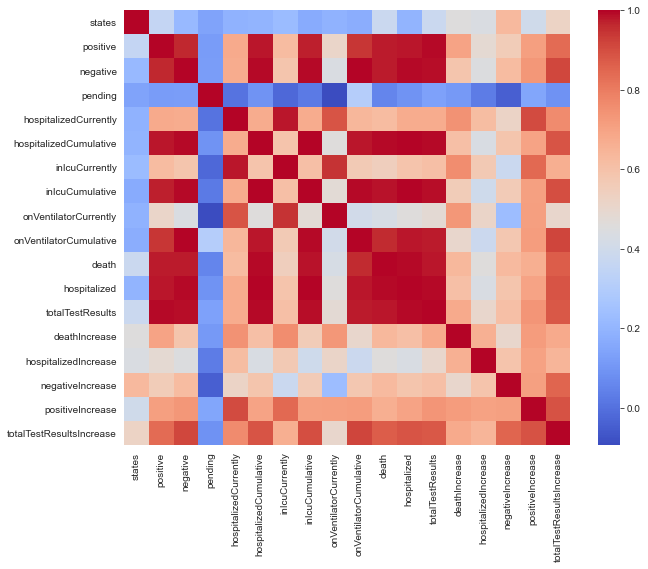

In [31]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(data_api.corr(), cmap='coolwarm')

Como podemos ver en el gráfico, hay una correlación alta entre el número de casos confirmados y el número de muertes y hospitalizaciones, esto podría indicar que los países con un alto número de casos confirmados también tienen un alto número de hospitalizaciones y muertes.

### Tasa de mortalidad diaria según casos positivos

In [32]:
# Tasa de mortalidad diaria = (Muertes reportadas en un día / Casos positivos reportados en un día) x 100
data_api['tmdIncrease'] = (data_api.deathIncrease / data_api.positive) * 100

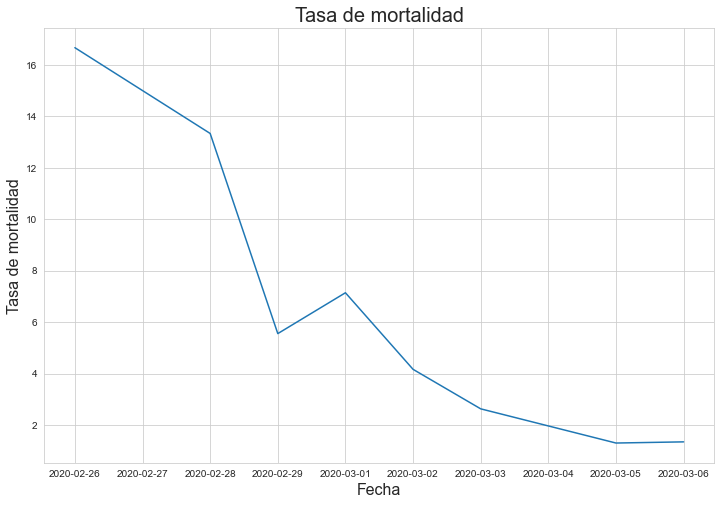

In [33]:
# Filtro para graficar tasa de mortalidad mayor a 1%
df_tmd = data_api[data_api['tmdIncrease'] > 1]

# Grafica
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=df_tmd, x='date', y='tmdIncrease')
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Tasa de mortalidad', fontsize=16)
plt.title('Tasa de mortalidad', fontsize=20)
plt.show()

Como se ve en el gráfico la tasa de mortalidad ha disminuido con el tiempo. Significa que una menor proporción de personas están muriendo en relación al número total de casos positivos. Esto podría ser indicativo de una mejor comprensión y tratamiento de la enfermedad por parte de los profesionales de la salud, así como de una mayor disponibilidad de recursos médicos y medidas preventivas para evitar contraer la enfermedad.

### Hospitalizaciones y muertes

In [34]:
data_api.hospitalizedCumulative.corr(data_api.death)

0.9931300952150707

In [35]:
data_api.dropna(inplace=True)

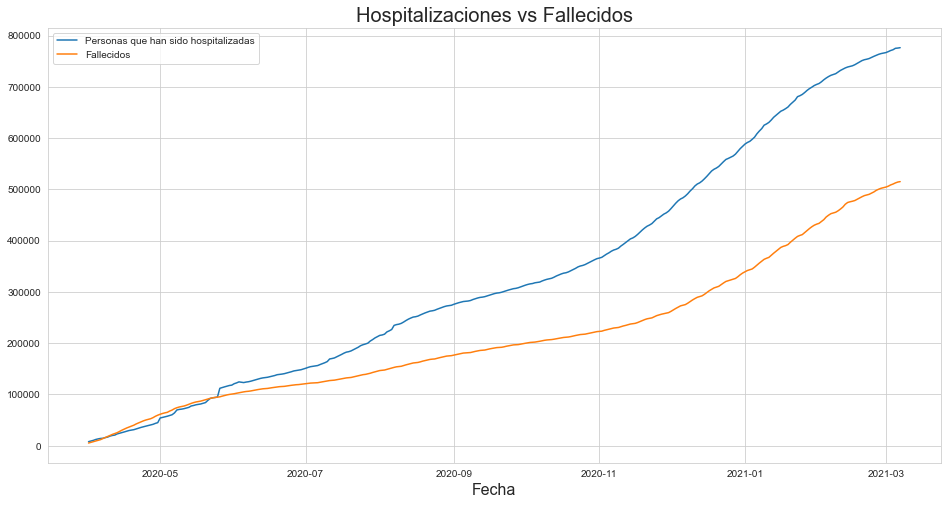

In [36]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_api.index, data_api.hospitalizedCumulative, label='Personas que han sido hospitalizadas')
ax.plot(data_api.index, data_api.death, label='Fallecidos')

ax.set_xlabel('Fecha', fontsize=16)  
ax.set_title('Hospitalizaciones vs Fallecidos', fontsize=20)
ax.legend()

 En este gráfico podemos ver que las lineas de hospitalizados y fallecidos comienza a separarse con el tiempo, esto puede ser una indicación de que el sistema de atención médica ha mejorado en su capacidad para tratar a los pacientes con COVID-19 y reducir la tasa de mortalidad.